# Computer Vision Lecture - Exercise 5 Part 2 - Recognition
In this exercise, you will gain hands-on experience regarding object recognition. More specifically, we will develop our own simple person detector using methods from classical image processing!

This notebook guides you through the relevant steps. When you see helper functions, you don't need to do anything - they are already implemented. The functions you need to implement are indicated as Exercise Function. Sometimes, you can find Hints - these are written upside-down so you can first try to find the solution without reading them.

Good luck and lot's of fun!

## Preliminaries
Let's first install dependencies and import the required libaries.

In [2]:
!pip install faiss-cpu --no-cache --quiet
import os
import numpy as np
from PIL import Image
import torch
import torchvision.datasets as datasets
from tqdm import tqdm
from skimage.feature import hog
from sklearn.svm import SVC
import faiss      # fast kNN search
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
# set random seed for reproducability
np.random.seed(42)

First, we load a the [Penn-Fudan Pedestrian Dataset](https://www.cis.upenn.edu/~jshi/ped_html/) and visualize some of its images.

In [3]:
###########################
##### Helper Function #####
###########################
class PennFudanDataset(torch.utils.data.Dataset):
  ''' Penn-Fudan Pedestrian dataset.
  Args:
  root (str): path to data directory
  split (str): dataset split, "train" or "val"
  '''
  def __init__(self, root, split='train'):
    self.root = root
    # download dataset if needed
    if not os.path.isdir(self.root):
      !wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip --directory-prefix=$self.root
      !unzip -qq $self.root/PennFudanPed.zip -d $self.root

    # load all image files, sorting them to
    # ensure that they are aligned
    imgs = list(sorted(os.listdir(os.path.join(root, "PennFudanPed","PNGImages"))))
    masks = list(sorted(os.listdir(os.path.join(root, "PennFudanPed", "PedMasks"))))

    # split into train and validation set
    ntrain = int(0.8*len(imgs))
    if split == 'train':
      self.imgs = imgs[:ntrain]
      self.masks = masks[:ntrain]
    elif split == 'val':
      self.imgs = imgs[ntrain:]
      self.masks = masks[ntrain:]
    else:
      raise AttributeError('split must be "train" or "val".')

  def __getitem__(self, idx):
    # load images and masks
    img_path = os.path.join(self.root, "PennFudanPed", "PNGImages", self.imgs[idx])
    mask_path = os.path.join(self.root, "PennFudanPed", "PedMasks", self.masks[idx])
    img = Image.open(img_path).convert("RGB")
    # note that we haven't converted the mask to RGB,
    # because each color corresponds to a different instance
    # with 0 being background

    mask = Image.open(mask_path)
    # convert the PIL Image into a numpy array
    mask = np.array(mask)
    # instances are encoded as different colors
    obj_ids = np.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]

    # split the color-encoded mask into a set
    # of binary masks
    masks = mask == obj_ids[:, None, None]

    # get bounding box coordinates for each mask
    num_objs = len(obj_ids)
    boxes = []
    for i in range(num_objs):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])
        boxes.append([xmin, ymin, xmax, ymax])

    return img, {'boxes': boxes}

  def __len__(self):
    return len(self.imgs)

In [4]:
###########################
##### Helper Function #####
###########################
def get_width_and_height(box):
  """ Helper function to determine size of bounding boxes.

  Args:
  box (iterable): (left, upper, right, lower) pixel coordinate
  """
  return box[2]-box[0], box[3]-box[1]

def draw_box(ax, box, color='r'):
  ''' Plot box on axes.

  Args:
  ax (matplotlib.axes.Axes): axes to add box to
  box (iterable): (left, upper, right, lower) pixel coordinate
  color (str or list): edgecolor of the box
  '''
  anchor = box[:2]
  W, H = get_width_and_height(box)
  patch = Rectangle(anchor, width=W, height=H, edgecolor=color, facecolor='none')
  ax.add_patch(patch)

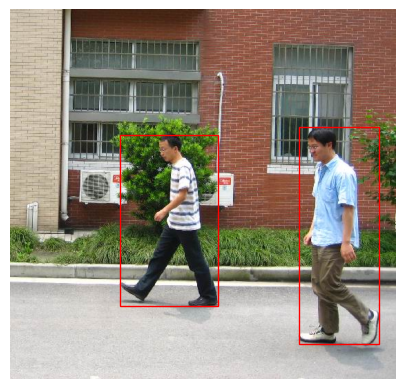

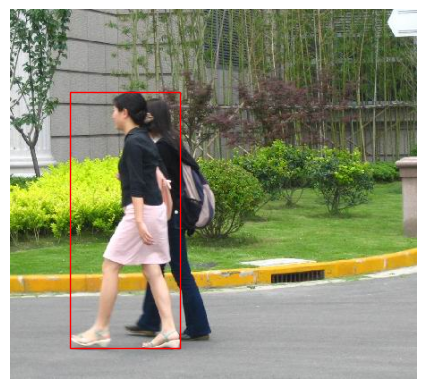

In [6]:
train_set = PennFudanDataset('data', split='train')
for i in range(2):
  img, annotation = train_set[i]
  fig, ax = plt.subplots(1)
  ax.set_axis_off()
  ax.imshow(img)
  for box in annotation['boxes']:
    draw_box(ax, box)

## Developing a Person Detector

Okay, we have our dataset so let's start to program our person detector! We will do this using a sliding window approach. The steps that we have to take are:

1.   Get **positive** training examples, i.e. image patches that contain a person.
2.   Get **negative** training examples, i.e. image patches that do not contain a (complete) person.
3.   Extract Histogram of Oriented Gradients (HOG) **features** to obtain a more robust image descriptor than the raw pixel values.
4.   **Train our preferred classifier** with this training data. We will implement a simple nearest neighbor search and a Support Vector Machine.
5.   Extract the image patches and HOG features from our validation image using a **sliding window approach and evaluate our classifier** on each patch to detect persons in the validation image.

### Getting the Training Patches

To obtain positive training examples, we can simply crop the training images according to the given bounding boxes.
We also resize the crops to a given size to ensure that all of our patches have the same size.

In [7]:
###########################
##### Helper Function #####
###########################
def get_resized_patch(img, box, patch_size):
  ''' Crop patch from image and resize it to given size.
  Args:
  img (PIL.Image.Image): image
  box (iterable): (left, upper, right, lower) pixel coordinate
  patch_size (tuple): width, height of resized patch
  '''
  assert isinstance(img, Image.Image), 'img needs to be PIL.Image.Image'
  crop = img.crop(box)
  patch = crop.resize(patch_size)
  return patch

Next, we need to get negative examples for training. Complete the function below, such that it places a box of a given size at a random location in the image. Ensure that the whole box is within the image boundaries. The function should return the (left, upper, right, lower) pixel coordinates of the box.

In [8]:
###########################
#### Exercise Function ####
###########################
def get_random_box(boxsize, imsize):
  """ Returns randomly located box with same size as box.

  Args:
  boxsize (tuple): width, height of box
  imsize (tuple): width, height of image / image boundaries
  """
  W, H = imsize
  # Insert your code here
  w,h = boxsize
  leftx = np.random.randint(0, W-w)
  lefty = np.random.randint(0,H-h)
  box = [leftx,lefty,leftx+w,lefty+h]
  assert all(b >= 0 for b in box) and (box[2] < W) and (box[3] < H), f'Box {box} out of image bounds {W, H}.'
  return box

In addition to these rather simple negative examples, let's also include some more challenging negative examples to improve the quality of our classifier later on. We construct hard negative examples by adding a small offset to the ground truth boxes. Thereby, the negative examples are close to positive detections.
Complete the function below, such that it adds a small random offset to a given box. The minimal offset in height/width should be 1 pixel and the maximal height/width offset should not exceed 20% of the box height/width.

In [19]:
###########################
#### Exercise Function ####
###########################
def add_offset_to_box(box, imsize):
  """ Add a small random integer offset to the box.

  Args:
  box (iterable): (left, upper, right, lower) pixel coordinate
  imsize (tuple): width, height of image / image boundaries
  """
  W, H = imsize
  w,h = get_width_and_height(box)
  # Insert your code here
  off_box = []
  of1 = np.random.randint(1,int(0.2*h)+1)
  of2 = np.random.randint(1,int(0.2*w)+1)

  of1 *= np.random.choice([-1,1])
  of2 *= np.random.choice([-1,1])

  off_box = [box[0]+of1,box[1]+of2,box[2]+of1,box[3]+of2]

  # ensure to stay within image boundaries / do not mind changing size slightly
  off_box[0] = max(0, off_box[0])
  off_box[1] = max(0, off_box[1])
  off_box[2] = min(W-1, off_box[2])
  off_box[3] = min(H-1, off_box[3])

  assert all(b >= 0 for b in off_box) and (off_box[2] < W) and (off_box[3] < H), f'Box {off_box} out of image bounds {W, H}.'

  return off_box


With these tools at hand, we can collect our training patches from the images.

In [11]:
###########################
##### Helper Function #####
###########################
def imgs_to_patches(train_set, patch_size, n_random_negatives=3, n_hard_negatives=3):
  positives = []
  negatives = []
  orig_sizes = []
  for img, annotation in tqdm(train_set):
    for box in annotation['boxes']:
      # keep track of original box sizes for sliding window approach later
      orig_sizes.append(np.array(get_width_and_height(box)))
      # extract positives
      positives.append(get_resized_patch(img, box, patch_size))
      # add some random negatives
      for _ in range(n_random_negatives):
        boxsize = get_width_and_height(box)
        mod_box = get_random_box(boxsize, img.size)
        negatives.append(get_resized_patch(img, mod_box, patch_size))
      # add some hard negatives by adding noise on box
      for _ in range(n_hard_negatives):
        mod_box = add_offset_to_box(box, img.size)
        negatives.append(get_resized_patch(img, mod_box, patch_size))
  return positives, negatives, orig_sizes

In [20]:
patch_size = (50, 150)          # hyperparameter
positives, negatives, orig_sizes = imgs_to_patches(train_set, patch_size)

100%|██████████| 136/136 [00:02<00:00, 54.11it/s]


Let's take a look at some of the positive and some of the negative patches to ensure everything is correct.

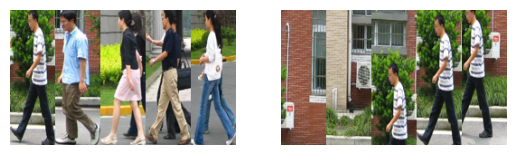

In [21]:
fig, ax = plt.subplots(1, 2)
ax[0].set_axis_off()
ax[0].imshow(np.concatenate([np.array(p) for p in positives[:5]], 1))

ax[1].set_axis_off()
ax[1].imshow(np.concatenate([np.array(n) for n in negatives[:5]], 1))


Do both positive and negative samples look reasonable? If they do, we can advance with the next step.

### Extracting HOG features

In the next steps, we convert the RGB pixel values from the image patches to more robust HOG features.

<ipython-input-30-d6b0cdc3efa8>:10: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), **kwargs,multichannel=True)


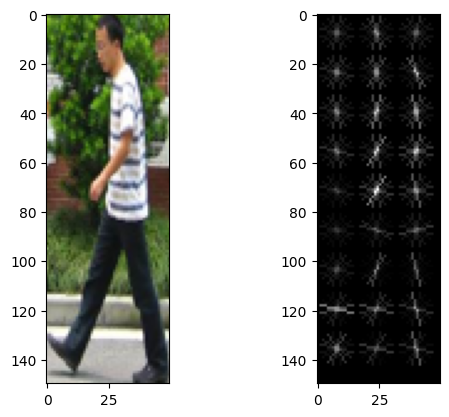

In [30]:
###########################
##### Helper Function #####
###########################
def get_hog(img, **kwargs):
  """ Extract HOG features with predefined settings.
  Args:
  img (np.ndarray): image with channel dimension last (HxWx3)
  """
  return hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), **kwargs,multichannel=True)

# visualize HOG for one image
img = np.array(positives[0])
fd, hog_image = get_hog(img, visualize=True)      # if visualize=True this function returns the descriptors + the image, otherwise it only returns the descriptors

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img)
ax[1].imshow(hog_image, cmap=plt.cm.gray)

In [27]:
fds_pos = []
for p in tqdm(positives, position=0, leave=True, desc='Extract HOG features for positive samples'):
  fds_pos.append(get_hog(p))
fds_neg = []
for n in tqdm(negatives, position=0, leave=True, desc='Extract HOG features for negative samples'):
  fds_neg.append(get_hog(n))

Extract HOG features for positive samples:   0%|          | 0/354 [00:00<?, ?it/s]<ipython-input-26-d6b0cdc3efa8>:10: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), **kwargs,multichannel=True)
Extract HOG features for negative samples: 100%|██████████| 2124/2124 [00:04<00:00, 427.93it/s]


### Training the classifiers

First, we construct our training set using the HOG feature descriptors from the previous step.

In [42]:
X = np.stack(fds_pos + fds_neg) #'+' for list object
y = np.concatenate([np.ones(len(positives), dtype=bool), np.zeros(len(negatives), dtype=bool)])

First, we train a simple nearest neighbor classifier. Since the sliding window approach will give us a lot of patches per image, a naive nearest neighbor approach can be very slow. Therefore, we use the [Faiss Library](https://github.com/facebookresearch/faiss) which is optimized for exactly such applications.


In [43]:
###########################
##### Helper Function #####
###########################
def init_nn_search(X):
  """ Initialize the index for a nearest neighbor search.
  Args:
  X (np.ndarray): training data
  """
  d = X.shape[1]
  quantizer = faiss.IndexFlatL2(d)                                  # measure L2 distance
  index = faiss.IndexIVFFlat(quantizer, d, 100, faiss.METRIC_L2)    # build the index
  index.train(X.astype(np.float32))
  index.add(X.astype(np.float32))                                   # add vectors to the index
  return index
index = init_nn_search(X)

Second, we train a support vector machine using `sklearn.svm.SVC`.

In [37]:
###########################
##### Helper Function #####
###########################
def train_svm(X, y):
  """ Train a support vector machine.
  Args:
  X (np.ndarray): training data
  y (np.ndarray): training labels
  """
  clf = SVC(class_weight='balanced')        # use balanced weight since we have more negatives than positives
  clf.fit(X, y)
  return clf

svm = train_svm(X, y)

### Evaluating the classifiers

In order to evaluate our classifiers, we need to extract the image patches and their HOG features from the target image, so that our target data is similar to our training data.
We do this using a sliding window approach.
Implement a function that extracts all crops of a given window size from an image in a sliding window manner. Similar to the training data, resize the crops to a given size and convert these patches to HOG features.
Your function should return two `numpy.ndarray`s. The first contains the feature descriptors of all patches in the image (Pxd), and the second contains the corresponding anchor, i.e. the (upper,left) pixel coordinate, of each patch (Px2).

In [44]:
###########################
#### Exercise Function ####
###########################
def img_to_hog_patches(img, window_size, patch_size, step_size=1):
  """ Extract hog feature patches from an image using a sliding window approach.

  Args:
  img (PIL.Image.Image): image
  window_size (tuple): width, height of window
  patch_size (tuple): width, height of resized patch
  step_size (int): step size of window (for faster evaluation)
  """
  # Insert your code here
  def sliding(imgsize,windowsize,step):
    W,H = imgsize
    w,h = windowsize
    for i in range(0,int(W-w),step):
      for j in range(0,int(H-h),step):
        yield(i,j,i+w,j+h)
  # convert to numpy arrays
  imgsize = img.size
  anchors = []
  fds = []
  for window in sliding(imgsize,window_size,step_size):
    anchors.append(window[:2])
    patch = get_resized_patch(img,window,patch_size)
    fds.append(get_hog(patch))
  fds = np.stack(fds)
  anchors = np.stack(anchors)
  return fds, anchors


Now, let us evaluate our classifiers on some new images.

<ipython-input-30-d6b0cdc3efa8>:10: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), **kwargs,multichannel=True)


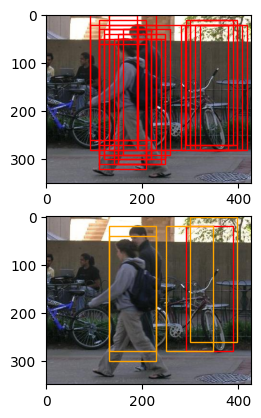

<ipython-input-30-d6b0cdc3efa8>:10: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), **kwargs,multichannel=True)


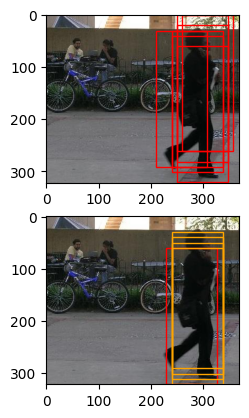

<ipython-input-30-d6b0cdc3efa8>:10: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), **kwargs,multichannel=True)


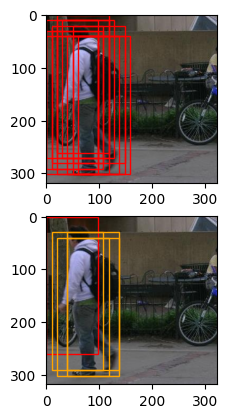

In [53]:
val_set = PennFudanDataset('data', split='val')
N_imgs = 3
window_size = np.stack(orig_sizes).mean(0).astype(np.uint)      # use average size of training boxes as window size

for i in range(N_imgs):
  img, ann = val_set[i]
  fds, anchors = img_to_hog_patches(img, window_size, patch_size, step_size=10)
  # evaluate NN search
  _, I = index.search(fds.astype(np.float32), 1)        # search nearest neighbor for each grid point
  # search in the previous set[X,y],for each grid window,find its nearest neighbor in the [X,y] set and return its index?
  is_positive = y[I]                                    # assign labels of training points
  #print(I)
  mask = is_positive.reshape(-1, 1).repeat(2, 1)        # convert to mask for anchors
  #print(mask,anchors[mask])
  anchors_nn = anchors[mask].reshape(-1, 2)

  # evaluate SVM
  k = 5
  scores = svm.predict(fds)
  idcs_sorted = np.argsort(scores)[::-1][:k]                # sort get top k predictions
  anchors_svm = anchors[idcs_sorted]

  # visualize the results
  fig, ax = plt.subplots(2)

  ax[0].imshow(img)
  for a in anchors_nn:
    box = (a[0], a[1], a[0]+window_size[0], a[1]+window_size[1])
    draw_box(ax[0], box, color='r')

  ax[1].imshow(img)
  for j, a in enumerate(anchors_svm):
    box = (a[0], a[1], a[0]+window_size[0], a[1]+window_size[1])
    color = 'r' if j == 0 else 'orange'
    draw_box(ax[1], box, color=color)

  plt.show()


Great job! While not perfect, HOG features combined with a simple classifier yield reasonable detections for this dataset.
You now gained hands-on experience in the fields of image detection!